c:\Users\arifu\Documents\Homework\2ndYear\miniconda3\envs\ml-env\lib\site-packages\xgboost\training.py:183: UserWarning: [15:32:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation ROC-AUC: 0.6040
              precision    recall  f1-score   support

           0       0.97      0.72      0.83    114704
           1       0.05      0.43      0.10      4339

    accuracy                           0.71    119043
   macro avg       0.51      0.57      0.46    119043
weighted avg       0.94      0.71      0.80    119043



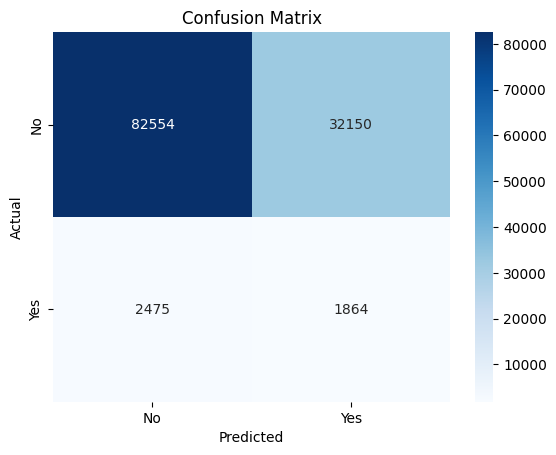

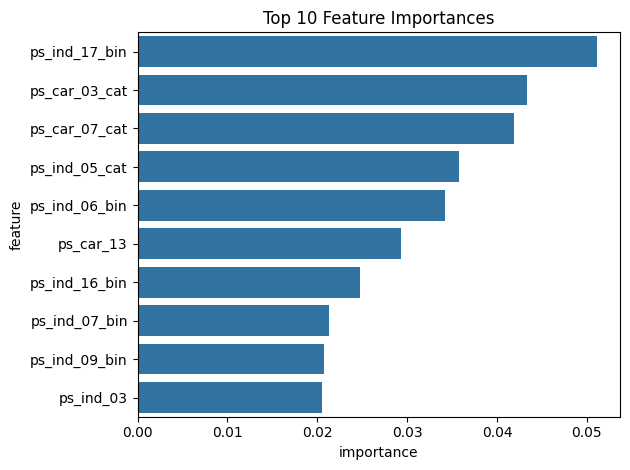

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from xgboost import XGBClassifier

# Load Data
df_train = pd.read_csv("train.csv", index_col=0)
df_test = pd.read_csv("test.csv", index_col=0)
y = df_train["target"]
X = df_train.drop(columns=["target"])
df_test = df_test.copy()

if 'id' in X.columns:
    X = X.drop(columns=['id'])
if 'id' in df_test.columns:
    df_test = df_test.drop(columns=['id'])

num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = [col for col in X.columns if '_cat' in col]

# Impute missing numeric values
imputer = SimpleImputer(strategy='median')
X[num_cols] = imputer.fit_transform(X[num_cols])
df_test[num_cols] = imputer.transform(df_test[num_cols])

# Encode categorical columns (label encoding is fine for XGBoost)
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    df_test[col] = le.transform(df_test[col])

# Feature scaling 
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])
df_test[num_cols] = scaler.transform(df_test[num_cols])

# Align columns
df_test = df_test[X.columns]

# Stratified train/validation split
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# Handle class imbalance
pos = sum(y_train == 1)
neg = sum(y_train == 0)
scale_pos_weight = neg / pos

# Model training
model = XGBClassifier(scale_pos_weight=scale_pos_weight, use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Evaluation
y_proba = model.predict_proba(X_valid)[:, 1]
y_pred = model.predict(X_valid)
print(f"Validation ROC-AUC: {roc_auc_score(y_valid, y_proba):.4f}")
print(classification_report(y_valid, y_pred))

cm = confusion_matrix(y_valid, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])    


# Feature importance confusion matrix
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Feature importance graph
importances = model.feature_importances_
feat_names = X.columns
imp_df = pd.DataFrame({'feature': feat_names, 'importance': importances}).sort_values(by='importance', ascending=False)

# Plot
sns.barplot(x='importance', y='feature', data=imp_df.head(10))
plt.title("Top 10 Feature Importances")
plt.tight_layout()
plt.show()




